In [1]:
import numpy as np
from datetime import *
import requests as Req
from lxml import etree
from typing import List

In [2]:
#根据基金代码到 天天基金网拉取数据
# http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code=020003&page=10&per=20&sdate=2016-10-01&edate=2017-10-01
#lsjz 历史净值
#code 基金代码
#sdate 开始时间 格式:2016-10-01 
#edate 结束时间 格式:2017-10-01
#per 每页多少条
#page 第几页
#返回 [(日期,净值,增长率)]
def get_raw_data(code: str, sdate: date = None, edate: date = None) -> str:
    if edate is None:
        edate = datetime.now().date()

    if sdate is None:
        sdate = date(edate.year - 3, edate.month, edate.day)

    print(code, sdate, edate)

    url: str = f"http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code={code}&page=1&per=3000&sdate={sdate}&edate={edate}"
    print("开始加载数据", url)

    resp: Req.Response = Req.get(url, headers={
        "user-agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
        "Accept-Encoding": "gzip, deflate",
        "Accept-Language": "zh-CN,zh;q=0.8,en-US;q=0.6,en;q=0.4"})

    result_str: str = resp.content.decode("utf-8")
    #    print(result_str)
    #    print(result_str.index("<table"), result_str.index("table>"))
    data_str: str = result_str[result_str.index("<table"):result_str.index("table>") + len("table>")]
    #print(data_str)
    return data_str

def _if(flag: bool, a, b):
    if flag:
        return a
    return b

def try_float(s: str, _default: float = 0.0)-> float:
    try:
        return float(s)
    except ValueError:
        return _default
    

def get_fund_data(code: str, sdate: date = None, edate: date = None)-> np.ndarray:
    data_str: str = get_raw_data(code, sdate, edate)
    el: etree._Element = etree.HTML(data_str)
    trList: List[etree._Element] = el.xpath("//tbody/tr")
    data: np.ndarray = np.array([[td for td in tr.xpath("./td/text()")[:4]] for tr in trList])
    data = np.array(
        [[datetime.strptime(row[0], '%Y-%m-%d'), try_float(row[1]), try_float(row[2]), try_float(row[3][:-1])] for row
         in data])
    data = data[::-1]
    return data


000697 2016-10-01 2017-10-04
开始加载数据 http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code=000697&page=1&per=3000&sdate=2016-10-01&edate=2017-10-04
245 [[datetime.datetime(2016, 10, 10, 0, 0) 1.598 1.598 2.7]
 [datetime.datetime(2016, 10, 11, 0, 0) 1.598 1.598 0.0]
 [datetime.datetime(2016, 10, 12, 0, 0) 1.595 1.595 -0.19]]
总投入 = 24500	最终余额 = [22604.560479177162]	增长率 = [-7.736487840093216]%	一次性投24500	
总投入 = 24500	最终余额 = [25682.004935583147]	增长率 = [4.824509941155703]%	每天投100	
总投入 = 28650.0	最终余额 = [28608.80849725727]	增长率 = [-0.14377487868318062]%	每天投0	


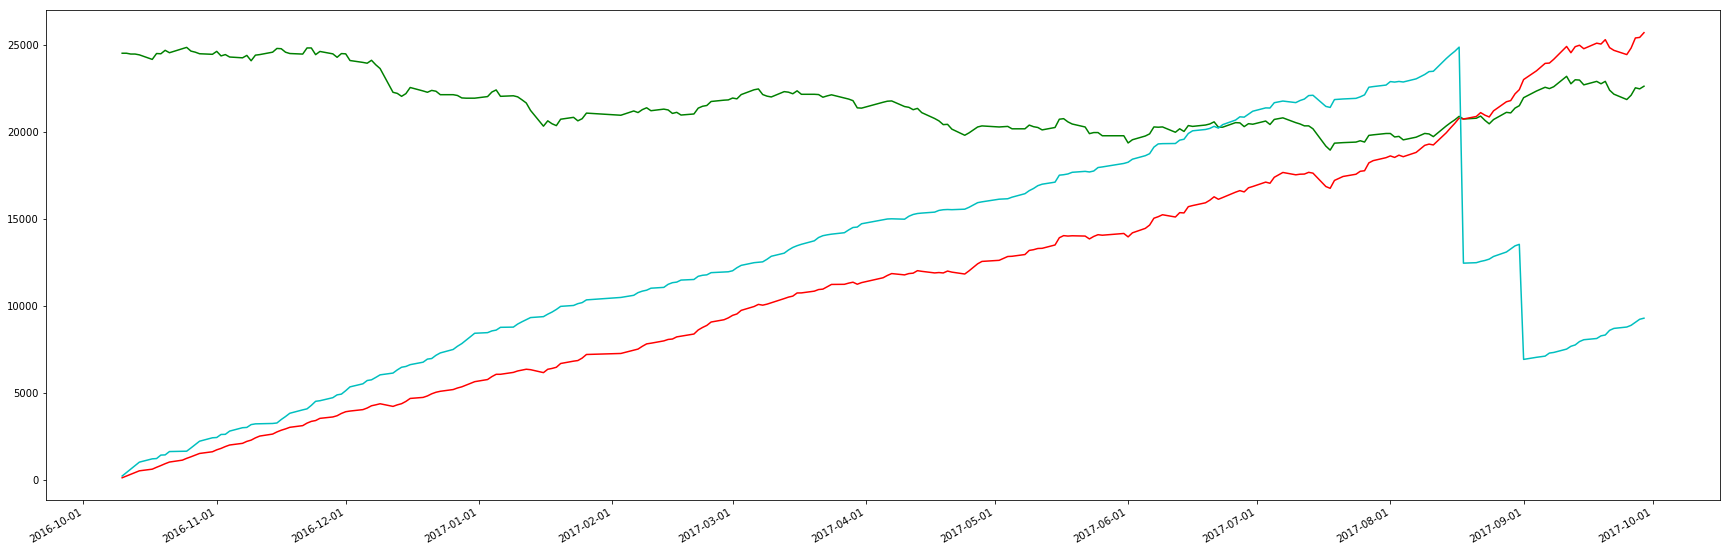

In [58]:
#sdate 开始日期,设置为空, 默认为现在时间的三年前
#edate 结束日期, 默认为现在时间
"""
国泰金龙行业精选(020003)
上投摩根行业轮动混合A(377530)  
金鹰核心资源混合(210009)
易方达上证50指数A(110003)
建信中证500指数增强(000478)
国泰纳斯达克100指数(160213)
招商中证白酒指数分级(161725)
广发全球精选股票(QDII)(270023)
上投摩根核心成长(000457)
嘉实全球互联网股票人民币(000988)
摩根太平洋证券人民币 968010
嘉实沪港深精选股票(001878)
鹏华创业板分级(160637)
中邮创新优势灵活配置混合(001275)
长信量化先锋混合A(519983)
汇添富移动互联股票(000697)
"""
data:np.ndarray = get_fund_data("000697", sdate=date(2016, 10, 1))
print(len(data), data[:3])

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# import pylab as plt
from matplotlib.lines import Line2D

#data = data[:10]
# 生成横纵坐标信息
xd: np.ndarray = np.array([_date[0] for _date in data[0:len(data), 0:1]])
value_yd: np.ndarray = np.array([data[i][2] for i in range(0, len(xd))])

#设置图片大小
plt.figure(figsize=(30, 10))

# 配置横坐标
axais = plt.gca().xaxis
axais.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axais.set_major_locator(mdates.MonthLocator())
# 绘制
#valPlt:Line2D = plt.plot(xd, value_yd, "r")

changes = data[0:len(data), 3:4]
days_count: int = len(data)


def invest_once(changes: List[float], invest: float = 1.0)-> List[float]:
    balances: List[float] = [invest]
    for i in range(1, len(changes)):
        balances.append(balances[-1] * (100 + changes[i]) / 100)
    final: float = balances[-1]
    print(f"总投入 = {invest}\t最终余额 = {final}\t增长率 = {(final - invest) / invest * 100}%\t一次性投{invest}\t")
    return balances


once_plt: Line2D = plt.plot(xd, invest_once(changes, 100 * days_count), "g")


def static_plan(changes: List[float], invest: float = 100)-> List[float]:
    balances: List[float] = [invest]
    invest_sum: float = invest
    for i in range(1, len(changes)):
        invest_sum += invest
        balances.append(invest + balances[-1] * (100 + changes[i]) / 100)

    final: float = balances[-1]
    print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
    return balances


day_100_plt: Line2D = plt.plot(xd, static_plan(changes, 100), "r")


def dynamic_plan_1(changes: List[float], invest: float = 100)-> List[float]:
    balances: List[float] = [invest]
    invest_sum: float = invest
    final: float = 0
    for i in range(1, len(changes)):
        change: float = changes[i]
        if change > 0:  #涨就不投
            invest = 0

        if change <= 0:  #跌就投
            invest = balances[0]

        if change < -1.5:  #跌幅大于1.5, 多投20%
            invest *= 1.5
        if change < -2:  #跌幅大于2, 多投50%
            invest *= 1.5
            
        if i > 5 and i % 5 == 0: 
            change_5days:float = sum(changes[i - 5:i])
            if change_5days > 5: #如果比5天前涨5% #其实止盈是没用的?
                final += balances[-1] / 2
                balances[-1] -= balances[-1] / 2 #抛出一半
            if change_5days < -5: #如果比5天前跌5%
#                 invest = balances[-1] / 2 #加仓一半 #其实加仓也是没用的?
                final += balances[-1] / 2
                balances[-1] -= balances[-1] / 2 #抛出一半
#             else:
#                 invest = balances[0]

        balances.append(invest + balances[-1] * (100 + change) / 100)
        invest_sum += invest
        
    final += balances[-1]
    print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
    return balances


dynamic_100_plt: Line2D = plt.plot(xd, dynamic_plan_1(changes, 200), "c")

# plt.legend([once_plt, day_100_plt, dynamic_plan_1], ("once", "day_100", "dynamic_plan_1"))

plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.show()


初步结论:
观察了若干基金一年内的波动情况,模拟了3种简单的定投方式
结论是,对于上涨趋势的基金,固定金额的定投就好
止损或者止盈反而减少收益

对于下跌较多的基金
止损比较有意义